In [40]:
import os
import pandas as pd
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.models import Model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import joblib
import pickle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve

import seaborn as sns


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
X_train = np.load('drive/MyDrive/lid_data/X_train.npy')
y_train = np.load('drive/MyDrive/lid_data/y_train.npy')

In [5]:
X_validation = np.load('drive/MyDrive/lid_data/X_validation.npy')
y_validation = np.load('drive/MyDrive/lid_data/y_validation.npy')

In [6]:
X_test = np.load('drive/MyDrive/lid_data/X_test.npy')
y_test = np.load('drive/MyDrive/lid_data/y_test.npy')

In [7]:
print(X_train.shape)

print(X_test.shape)

print(X_validation.shape)

(10336, 188, 13)
(1292, 188, 13)
(1292, 188, 13)


In [8]:
print(y_train.shape)

print(y_test.shape)

print(y_validation.shape)

(10336,)
(1292,)
(1292,)


In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

In [9]:
print(unique_elements,counts_elements)

[0 1 2 3 4] [2285 1910 1975 1947 2219]


In [10]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(unique_elements,counts_elements)

[0 1 2 3 4] [264 238 251 264 275]


In [9]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [13]:

EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
PATIENCE = 5

In [14]:

class_list, frequency = np.unique(y_train,return_counts = True)

print(class_list)

NCLASS=len(class_list)


print(NCLASS)



[0 1 2 3 4]
5


In [31]:
class_names = ['English','French', 'German','Portuguese','Tamil']

In [23]:
teacher_model = load_model("drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras")

In [24]:
test_loss, test_acc = teacher_model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy on best model: {}".format(test_loss, 100*test_acc))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9402 - loss: 0.2241

Test loss: 0.23919181525707245, test accuracy on best model: 93.11145544052124


10
[<Conv1D name=conv1d_6, built=True>, <Conv1D name=conv1d_7, built=True>, <Conv1D name=conv1d_8, built=True>, <GlobalAveragePooling1D name=global_average_pooling1d_2, built=True>, <Flatten name=flatten_2, built=True>, <Dense name=dense_6, built=True>, <Dropout name=dropout_4, built=True>, <Dense name=dense_7, built=True>, <Dropout name=dropout_5, built=True>, <Dense name=dense_8, built=True>]
10


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 188, 13)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 182, 500)            │         450,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,800 (2.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 544,800 (2.08 MB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


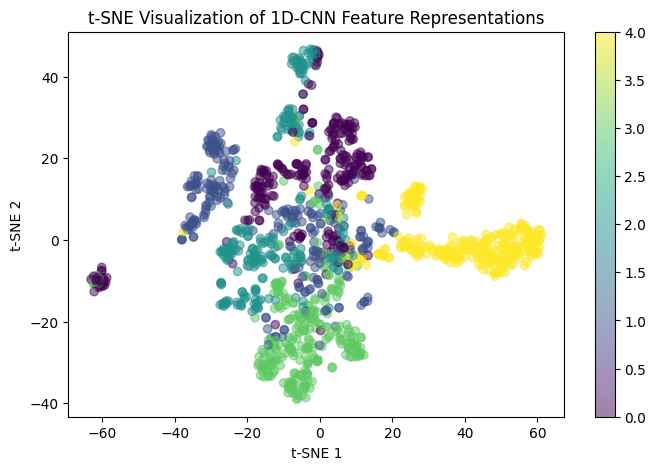

In [29]:
num_layers = len(teacher_model.layers)

print(num_layers)

print(teacher_model.layers)

# Freeze all layers except the last one
count = 0
for layer in teacher_model.layers:
  layer.trainable = False
  count += 1

print(count)


input_layer_input = teacher_model.layers[-10].input

last_layer_output = teacher_model.layers[-6].output

# Create a new model to output the feature representations
intermediate_layer_model = Model(inputs=input_layer_input, outputs=last_layer_output)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.99)

intermediate_layer_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",metrics=["accuracy"])

intermediate_layer_model.summary()



# Get feature representations for the training data
features = intermediate_layer_model.predict(X_test)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE output
plt.figure(figsize=(8, 5))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization of 1D-CNN Feature Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

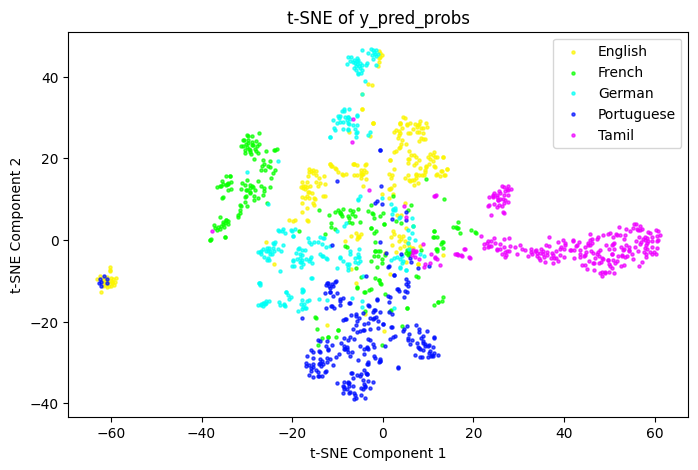

In [32]:
# Plot the data with different colors for different classes
plt.figure(figsize=(8, 5))
palette = sns.color_palette("hsv", len(class_names)) # Choose a color palette

for i, label in enumerate(class_names):
    idx = y_test == i
    plt.scatter(features_2d[idx, 0],features_2d[idx, 1], s=5, alpha=0.7, color=palette[i], label=class_names[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

#KD starts here.........

In [11]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, GlobalAveragePooling1D, Dense, MaxPooling1D
def build_1D_student_CNN_model(input_shape, NCLASS, learning_rate , loss="sparse_categorical_crossentropy"):
    model = Sequential()

    # Add 1D-CNN layers
    model.add(Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape= input_shape))   #(None, 1)
    model.add(Conv1D(filters=300, kernel_size=3, strides=1, activation='relu'))


    # Global average pooling
    model.add(GlobalAveragePooling1D())

    model.add(Flatten())
    # Fully connected layers

    model.add(Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    # Softmax layer
    model.add(Dense(NCLASS, activation='softmax'))

    model.summary()

    return model

In [10]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student


    def call(self, inputs):
        # Forward pass of the student model
        return self.student(inputs)

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    def predict_step(self, data):
        # Unpack the data
        x = data

        # Compute predictions
        return self.student(x, training=False)

In [15]:
student_model = build_1D_student_CNN_model(input_shape, NCLASS, learning_rate=LEARNING_RATE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,129 (734.88 KB)

 Trainable params: 188,129 (734.88 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
teacher_model = load_model("drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras")

In [17]:
teacher_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 182, 500)            │         450,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         256,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,602,865 (9.93 MB)

 Trainable params: 867,621 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,735,244 (6.62 MB)

In [18]:
# Compile the distiller model with SGD optimizer
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.99),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)


#checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Distill teacher to student and store the training history
history_distill = distiller.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_validation, y_validation), verbose=1)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - sparse_categorical_accuracy: 0.3978 - distillation_loss: 0.0633 - loss: 0.2000 - student_loss: 1.1818 - val_loss: 0.2000 - val_student_loss: 1.0769
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - sparse_categorical_accuracy: 0.6521 - distillation_loss: 0.0445 - loss: 0.2000 - student_loss: 0.8585 - val_loss: 0.2000 - val_student_loss: 0.8465
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - sparse_categorical_accuracy: 0.7312 - distillation_loss: 0.0360 - loss: 0.2000 - student_loss: 0.7202 - val_loss: 0.2000 - val_student_loss: 0.9269
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - sparse_categorical_accuracy: 0.7669 - distillation_loss: 0.0305 - loss: 0.2000 - student_loss: 0.6279 - val_loss: 0.2000 - val_student_loss: 0.8490
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - sparse_categorical_accuracy: 0.7986 - distillation_loss: 0.0272 - loss: 0.2000 - student_loss: 0.5712 - val_loss: 0.2000 - val_student_loss: 0.660

In [19]:
evaluation_result = distiller.evaluate(X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - sparse_categorical_accuracy: 0.9261 - loss: 0.2000 - student_loss: 0.2720


In [20]:
SAVED_MODEL_PATH = "drive/MyDrive/lid_kd_project/student_1D_CNN_model_best.keras"

# save model
student_model.save(SAVED_MODEL_PATH)

# evaluate latest network on test set
evaluation_result = distiller.evaluate(X_test, y_test)
#print("\nTest loss: {}, test accuracy on last model: {}".format(test_loss, 100*test_acc))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - sparse_categorical_accuracy: 0.9261 - loss: 0.2000 - student_loss: 0.2720


In [33]:
student_model = load_model("drive/MyDrive/lid_kd_project/student_1D_CNN_model_best.keras")

In [34]:
student_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,129 (734.88 KB)

 Trainable params: 188,129 (734.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,129 (734.88 KB)

 Trainable params: 188,129 (734.88 KB)

 Non-trainable params: 0 (0.00 B)

9
[<Conv1D name=conv1d, built=True>, <Conv1D name=conv1d_1, built=True>, <GlobalAveragePooling1D name=global_average_pooling1d, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dropout name=dropout, built=True>, <Dense name=dense_1, built=True>, <Dropout name=dropout_1, built=True>, <Dense name=dense_2, built=True>]
9


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 188, 13)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 300)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,300 (368.36 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 94,300 (368.36 KB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


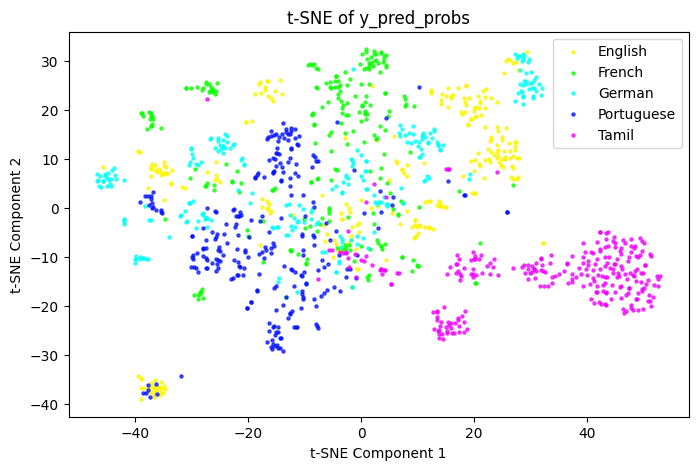

In [37]:
student_model = load_model("drive/MyDrive/lid_kd_project/student_1D_CNN_model_best.keras")

student_model.summary()

num_layers = len(student_model.layers)

print(num_layers)

print(student_model.layers)

# Freeze all layers except the last one
count = 0
for layer in student_model.layers:
  layer.trainable = False
  count += 1

print(count)


input_layer_input = student_model.layers[-9].input

last_layer_output = student_model.layers[-6].output

# Create a new model to output the feature representations
intermediate_layer_model = Model(inputs=input_layer_input, outputs=last_layer_output)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.99)

intermediate_layer_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",metrics=["accuracy"])

intermediate_layer_model.summary()



# Get feature representations for the training data
features = intermediate_layer_model.predict(X_test)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)





# Plot the data with different colors for different classes
plt.figure(figsize=(8, 5))
palette = sns.color_palette("hsv", len(class_names)) # Choose a color palette

for i, label in enumerate(class_names):
    idx = y_test == i
    plt.scatter(features_2d[idx, 0],features_2d[idx, 1], s=5, alpha=0.7, color=palette[i], label=class_names[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9261 - loss: 0.2736

Test loss: 0.2770003378391266, test accuracy on best model: 91.40866994857788
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
[[239   8  11   6   0]
 [ 10 212   9   6   1]
 [  6   6 236   3   0]
 [ 13  13   8 229   1]
 [  3   5   1   1 265]]
              precision    recall  f1-score   support

     English       0.88      0.91      0.89       264
      French       0.87      0.89      0.88       238
      German       0.89      0.94      0.91       251
  Portuguese       0.93      0.87      0.90       264
       Tamil       0.99      0.96      0.98       275

    accuracy                           0.91      1292
   macro avg       0.91      0.91      0.91      1292
weighted avg       0.92      0.91      0.91      1292


Precision: 0.9155145414575223
Recall: 0.9140866873065016
F1 Score: 0.9143114280041535
Macro-average AUC-ROC Score: 0.9908620792246348
Weighted-average AUC-ROC Score: 0.990969963904691


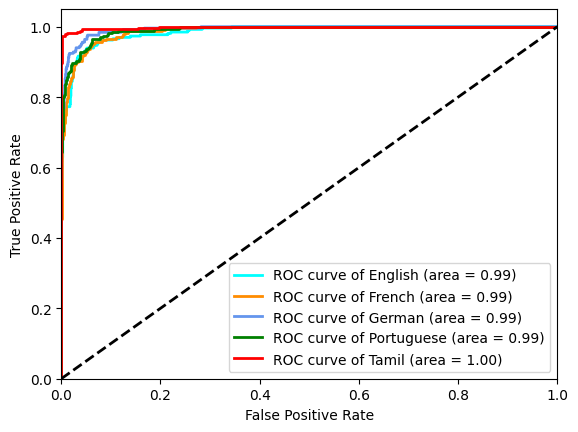

In [42]:
# evaluate the best network on test set
student_model = load_model("drive/MyDrive/lid_kd_project/student_1D_CNN_model_best.keras")
student_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",metrics=["accuracy"])
test_loss, test_acc = student_model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy on best model: {}".format(test_loss, 100*test_acc))



# Making predictions on the test set
y_pred_probs = student_model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# show classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Binarize the output labels for multiclass ROC AUC computation
y_bin = label_binarize(y_test, classes=np.arange(NCLASS))

#print(f"y shape: {y.shape}")
#print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Compute AUC-ROC score for each class
auc_scores = []
for i in range(NCLASS):
    auc = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
    auc_scores.append(auc)
    #print(f"AUC-ROC Score for class {class_names[i]}: {auc}")

# Compute macro-average AUC-ROC score
macro_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="macro", multi_class="ovr")
print(f"Macro-average AUC-ROC Score: {macro_roc_auc_ovr}")

# Compute weighted-average AUC-ROC score
weighted_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="weighted", multi_class="ovr")
print(f"Weighted-average AUC-ROC Score: {weighted_roc_auc_ovr}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(NCLASS):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure()
for i, color in zip(range(NCLASS), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], auc_scores[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()